### Edit Videos

In [23]:
import os
import subprocess
import imageio_ffmpeg as ffmpeg

input_folder = "../real_videos_raw/"
output_folder = "../real_videos_segments/"
os.makedirs(output_folder, exist_ok=True)

SEG = 8

def split_ffmpeg(input_path, output_folder, segment_length=8):
    ffmpeg_path = ffmpeg.get_ffmpeg_exe()
    base = os.path.splitext(os.path.basename(input_path))[0]

    cmd = [
        ffmpeg_path,
        "-i", input_path,
        "-c", "copy",
        "-map", "0",
        "-segment_time", str(segment_length),
        "-f", "segment",
        os.path.join(output_folder, f"{base}_part%03d.mp4")
    ]

    print("Running:", " ".join(cmd))
    subprocess.run(cmd)
    print(f"Finished: {base}")

for file in os.listdir(input_folder):
    if file.lower().endswith((".mp4", ".mov", ".avi", ".mkv")):
        full_path = os.path.join(input_folder, file)
        print("Processing:", file)
        split_ffmpeg(full_path, output_folder, SEG)


Processing: Apple - Wonderful Tools (60fps) - David (1080p, h264, youtube).mp4
Running: c:\Users\lixin\anaconda3\Lib\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe -i ../real_videos_raw/Apple - Wonderful Tools (60fps) - David (1080p, h264, youtube).mp4 -c copy -map 0 -segment_time 8 -f segment ../real_videos_segments/Apple - Wonderful Tools (60fps) - David (1080p, h264, youtube)_part%03d.mp4
Finished: Apple - Wonderful Tools (60fps) - David (1080p, h264, youtube)
Processing: Better in Denim. - Gap (1080p, h264, youtube).mp4
Running: c:\Users\lixin\anaconda3\Lib\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe -i ../real_videos_raw/Better in Denim. - Gap (1080p, h264, youtube).mp4 -c copy -map 0 -segment_time 8 -f segment ../real_videos_segments/Better in Denim. - Gap (1080p, h264, youtube)_part%03d.mp4
Finished: Better in Denim. - Gap (1080p, h264, youtube)
Processing: Every product carbon neutral by 2030  Apple - Apple (1080p, h264, youtube).mp4
Runni

### Extract_features（Real_videos)

In [ ]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

RESIZE_W, RESIZE_H = 640, 360
MIN_FRAMES = 20

ROOT = r"C:\Users\lixin\Desktop\E1"

real_segment_folder = os.path.join(ROOT, "real_videos_segments")
real_feature_folder = os.path.join(ROOT, "Real_features", "frame_data")

os.makedirs(real_feature_folder, exist_ok=True)

In [28]:
def compute_flow(prev, curr):
    flow = cv2.calcOpticalFlowFarneback(
        prev, curr, None,
        0.5, 3, 15, 5, 5, 1.2, 0
    )
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return mag, ang

In [29]:
def extract_frame_series(video_path, video_id):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Cannot open video: {video_path}")
        return False

    mags, dir_mean, dir_std, all_dirs, diffs = [], [], [], [], []

    ret, prev = cap.read()
    if not ret:
        return False

    prev = cv2.resize(prev, (RESIZE_W, RESIZE_H))
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (RESIZE_W, RESIZE_H))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        mag, ang = compute_flow(prev_gray, gray)

        mags.append(np.mean(mag))
        dir_mean.append(np.mean(ang))
        dir_std.append(np.std(ang))
        all_dirs.extend(ang.flatten())

        diffs.append(np.mean(cv2.absdiff(prev_gray, gray)))

        prev_gray = gray

    cap.release()

    if len(mags) < MIN_FRAMES:
        return False

    if len(all_dirs) > 0:
        dir_hist, _ = np.histogram(all_dirs, bins=36, range=(0, 2*np.pi))
    else:
        dir_hist = np.zeros(36)

    np.save(os.path.join(real_feature_folder, f"{video_id}_mags.npy"), np.array(mags))
    np.save(os.path.join(real_feature_folder, f"{video_id}_dir_mean.npy"), np.array(dir_mean))
    np.save(os.path.join(real_feature_folder, f"{video_id}_dir_std.npy"), np.array(dir_std))
    np.save(os.path.join(real_feature_folder, f"{video_id}_dir_hist.npy"), dir_hist)
    np.save(os.path.join(real_feature_folder, f"{video_id}_diffs.npy"), np.array(diffs))

    return True

real_metadata = []

for file in tqdm(os.listdir(real_segment_folder)):
    if file.lower().endswith((".mp4", ".mov", ".avi", ".mkv")):
        vid = os.path.splitext(file)[0]
        path = os.path.join(real_segment_folder, file)

        ok = extract_frame_series(path, vid)
        if ok:
            real_metadata.append({"video_id": vid, "filepath": path})

real_df = pd.DataFrame(real_metadata)
real_df.to_csv(os.path.join(ROOT, "real_metadata.csv"), index=False)

100%|██████████| 53/53 [21:39<00:00, 24.52s/it]


### Temporal_features (Real_videos)

In [30]:
from scipy.signal import find_peaks, detrend
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

In [31]:
ROOT = r"C:\Users\lixin\Desktop\E1"

frame_root = os.path.join(ROOT, "Real_features", "frame_data")
save_path = os.path.join(ROOT, "Real_features", "real_temporal_features.csv")

In [32]:
def safe_load(path):
    if not os.path.exists(path):
        return None
    return np.load(path)

def compute_trend_r2(mags):
    t = np.arange(len(mags)).reshape(-1, 1)
    reg = LinearRegression().fit(t, mags)
    pred = reg.predict(t)

    ss_res = np.sum((mags - pred) ** 2)
    ss_tot = np.sum((mags - np.mean(mags)) ** 2)
    return 1 - ss_res / ss_tot if ss_tot > 0 else 0

def compute_rhythm_strength(mags):
    mags_d = detrend(mags)
    fft_vals = np.abs(np.fft.rfft(mags_d))
    fft_vals[0] = 0
    if np.sum(fft_vals) == 0:
        return 0
    return np.max(fft_vals) / np.sum(fft_vals)

def compute_cycle_score(mags):
    peaks, _ = find_peaks(mags, distance=5)
    if len(peaks) < 2:
        return 0
    intervals = np.diff(peaks)
    return np.std(intervals)

def compute_pause_ratio(mags, ratio=0.15):
    thr = np.mean(mags) * ratio
    pauses = np.sum(mags < thr)
    return pauses / len(mags)

def compute_smoothness(mags):
    if len(mags) < 3:
        return 0
    accel = np.diff(mags)
    return 1 / (np.std(accel) + 1e-6)

def compute_complexity(mags):
    hist, _ = np.histogram(mags, bins=20)
    if hist.sum() == 0:
        return 0
    return entropy(hist / hist.sum())

def compute_direction_consistency(dir_mean, dir_std):
    return float(1 / (np.mean(dir_std) + 1e-6))

def compute_segment_count(diffs, thresh_ratio=0.2):
    thr = np.mean(diffs) * (1 + thresh_ratio)
    high_change = diffs > thr
    return int(np.sum(np.diff(high_change.astype(int)) == 1))

def compute_dir_hist_entropy(hist):
    if np.sum(hist) == 0:
        return 0
    return entropy(hist / np.sum(hist))

In [33]:
rows = []

for fname in tqdm(sorted(os.listdir(frame_root))):
    if not fname.endswith("_mags.npy"):
        continue

    video_id = fname.replace("_mags.npy", "")

    mags = safe_load(os.path.join(frame_root, f"{video_id}_mags.npy"))
    dir_mean = safe_load(os.path.join(frame_root, f"{video_id}_dir_mean.npy"))
    dir_std = safe_load(os.path.join(frame_root, f"{video_id}_dir_std.npy"))
    dir_hist = safe_load(os.path.join(frame_root, f"{video_id}_dir_hist.npy"))
    diffs = safe_load(os.path.join(frame_root, f"{video_id}_diffs.npy"))

    if mags is None or dir_mean is None or dir_std is None or diffs is None or dir_hist is None:
        continue

    row = {
        "video_id": video_id,

        "trend_r2": compute_trend_r2(mags),
        "smoothness": compute_smoothness(mags),

        "rhythm_strength": compute_rhythm_strength(mags),
        "cycle_score": compute_cycle_score(mags),

        "pause_ratio": compute_pause_ratio(mags),
        "segment_count": compute_segment_count(diffs),

        "speed_entropy": compute_complexity(mags),

        "direction_consistency": compute_direction_consistency(dir_mean, dir_std),
        "dir_hist_entropy": compute_dir_hist_entropy(dir_hist),

        "mean_speed": float(np.mean(mags)),
        "speed_std": float(np.std(mags)),
    }

    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv(save_path, index=False)

100%|██████████| 265/265 [00:02<00:00, 117.16it/s]


### Models

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from scipy.stats import ks_2samp
import umap

In [35]:
ROOT = r"C:\Users\lixin\Desktop\E1"

ai_path   = os.path.join(ROOT, "AI_features", "temporal_features.csv")
real_path = os.path.join(ROOT, "Real_features", "real_temporal_features.csv")

df_ai   = pd.read_csv(ai_path)
df_real = pd.read_csv(real_path)

df_ai["label"] = "AI"
df_real["label"] = "Real"

df_ai.head(), df_real.head()

(  video_id  trend_r2  smoothness  rhythm_strength  cycle_score  pause_ratio  \
 0    V-001  0.861713   37.452111         0.121926     1.818119     0.031414   
 1    V-002  0.845009   15.495925         0.184653     7.930252     0.214660   
 2    V-003  0.323647    1.041492         0.085367     2.397554     0.005236   
 3    V-004  0.094308   31.664858         0.544137     1.451158     0.099476   
 4    V-005  0.723790    9.070114         0.330082     2.129589     0.047120   
 
    segment_count  speed_entropy  direction_consistency  dir_hist_entropy  \
 0              2       2.765999               0.510251          3.556951   
 1              1       2.666871               0.436878          3.146965   
 2             10       1.995706               0.538073          3.507519   
 3              3       2.924647               0.720247          2.932000   
 4              5       2.376803               0.534134          3.498247   
 
    mean_speed  speed_std label  
 0    0.226785   0.1

In [36]:
df = pd.concat([df_ai, df_real], ignore_index=True)

df.shape, df["label"].value_counts()

((169, 13),
 label
 AI      116
 Real     53
 Name: count, dtype: int64)

In [37]:
FEATURE_COLS = [c for c in df.columns if c not in ["video_id", "label"]]

X = df[FEATURE_COLS].values
y = df["label"].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [39]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_s, y_train)

y_pred = logreg.predict(X_test_s)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

coef_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "coef": logreg.coef_[0]
}).sort_values("coef", ascending=False)

coef_df

=== Logistic Regression ===
Accuracy: 0.8604651162790697
              precision    recall  f1-score   support

          AI       0.85      0.97      0.91        30
        Real       0.89      0.62      0.73        13

    accuracy                           0.86        43
   macro avg       0.87      0.79      0.82        43
weighted avg       0.86      0.86      0.85        43



,feature,coef
7,direction_consistency,2.276939
10,speed_std,1.391510
8,dir_hist_entropy,-0.189534
4,pause_ratio,-0.289728
1,smoothness,-0.360739
9,mean_speed,-0.408973
3,cycle_score,-0.463248
0,trend_r2,-0.803761
5,segment_count,-0.896708
2,rhythm_strength,-1.311991


In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

imp_df = pd.DataFrame({
    "feature": FEATURE_COLS,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

imp_df

=== Random Forest ===
Accuracy: 0.8837209302325582
              precision    recall  f1-score   support

          AI       0.86      1.00      0.92        30
        Real       1.00      0.62      0.76        13

    accuracy                           0.88        43
   macro avg       0.93      0.81      0.84        43
weighted avg       0.90      0.88      0.87        43



,feature,importance
1,smoothness,0.199264
6,speed_entropy,0.164417
7,direction_consistency,0.140883
2,rhythm_strength,0.122752
5,segment_count,0.078241
10,speed_std,0.077174
3,cycle_score,0.063774
9,mean_speed,0.049628
4,pause_ratio,0.037032
8,dir_hist_entropy,0.033495


In [ ]:
ai_only = df_ai[FEATURE_COLS].values
scaler2 = StandardScaler()
ai_scaled = scaler2.fit_transform(ai_only)

ocsvm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm.fit(ai_scaled)

real_scaled = scaler2.transform(df_real[FEATURE_COLS].values)
pred_real = ocsvm.predict(real_scaled)

print("Outlier count (Real detected as non-AI):", np.sum(pred_real == -1))
print("Total real videos:", len(pred_real))

real_outlier_ratio = np.mean(pred_real == -1)
real_outlier_ratio

Outlier count (Real detected as non-AI): 34
Total real videos: 53


0.6415094339622641

In [42]:
ks_results = []

for f in FEATURE_COLS:
    ai_vals = df_ai[f].dropna()
    real_vals = df_real[f].dropna()

    stat, p = ks_2samp(ai_vals, real_vals)
    ks_results.append((f, stat, p))

ks_df = pd.DataFrame(ks_results, columns=["feature", "KS_stat", "p_value"])
ks_df.sort_values("p_value").head(10)

,feature,KS_stat,p_value
6,speed_entropy,0.642160,9.998301e-15
2,rhythm_strength,0.595316,1.425391e-12
1,smoothness,0.526187,8.669082e-10
0,trend_r2,0.486500,2.216637e-08
5,segment_count,0.478367,4.293405e-08
7,direction_consistency,0.448276,3.754951e-07
4,pause_ratio,0.352147,1.558825e-04
10,speed_std,0.292941,2.894471e-03
3,cycle_score,0.289850,3.274355e-03
8,dir_hist_entropy,0.149154,3.493507e-01


c:\Users\lixin\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


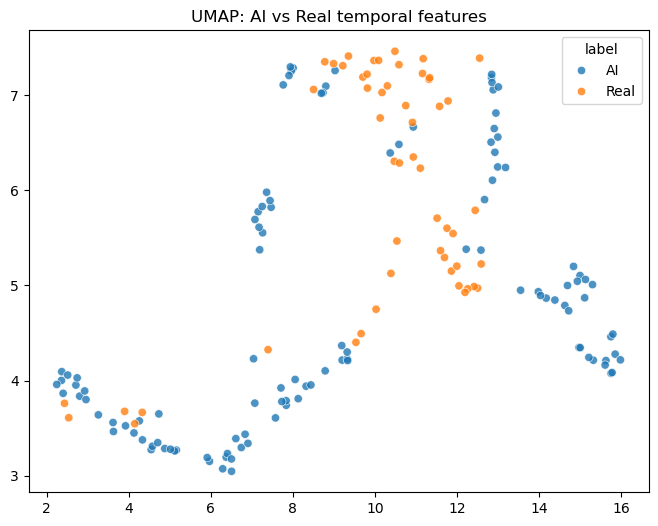

In [43]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df[FEATURE_COLS].values)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=embedding[:,0], y=embedding[:,1],
    hue=df["label"],
    alpha=0.8
)
plt.title("UMAP: AI vs Real temporal features")
plt.show()